In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from scipy.stats import norm
#import statsmodels.api as sm
from scipy.integrate import quad
import warnings
warnings.filterwarnings('ignore')

np.random.seed(1610)

## Test distributions

In [16]:
def gauss_dist(x, mu=0, sigma=1):    
    sigma = np.array(sigma)
    mu = np.array(mu)
    return 1/(np.multiply(sigma,np.sqrt(2*np.pi))) * np.exp(-(x-mu)**2/(2*sigma**2))


def dg(x, alpha=0.5, mu_1=-3, sigma_1=1, mu_2=3, sigma_2=1):
    return alpha*gauss_dist(x, mu_1,sigma_1 )+(1-alpha)*gauss_dist(x, mu_2,sigma_2 )


def dist_andreas(x, alpha=5):
    return np.exp(-(np.cos(-(x-alpha)+(-x+alpha)**2)-1)-0.1*(-x+alpha)**4)/6.90815481092748


def my_sampling(nTrials, xmin, xmax, dist_true, **params):
    
    x = np.linspace(xmin, xmax, 3000)
    max_dist = np.max(dist_true(x, **params))
    
    samplesTrial = xmin+(np.random.rand(nTrials)*(xmax-xmin))
    #only accecpt samples with a random y-coord from [0..something larger than maximum of curve] under the curve
    samples = samplesTrial[ 1.1*max_dist*np.random.rand(nTrials) < dist_true(samplesTrial, **params)]
    
    return samples, samplesTrial


def true_dist(case=0):
    if case==0:# Gaussian w. zero mean and 1 variance
        dist = lambda x: gauss_dist(x, mu=0, sigma=1)
        xmin = -5
        xmax=5
    if case==1: # Double Gaussian 
        dist = lambda x: dg(x, alpha=0.5, mu_1=-3, sigma_1=1, mu_2=3, sigma_2=1)
        xmin = -8
        xmax = 8
    if case==2: # Andreas' dist
        dist = lambda x: dist_andreas(x, alpha=5)
        xmin=1
        xmax=9
    
    return dist, xmin, xmax


def generate_noisy_sample(N=1000, case_dist=0, case_err=0, seed=1234):
    
    """
    N : number of points
    case_dist :  case for distribution of mass (x)
                0 :: gaussian mu=0, sigma=1
                1 :: double gaussian
                2 :: Andreas' dist.

    """
    np.random.seed(seed)   
    
    # Masses
    f, xmin, xmax = true_dist(case_dist)
    x, _ = my_sampling(5*N, xmin, xmax, f)
    Nsamples = x.size
    print('Got %s samples' %Nsamples)
    
    # Redshifts
    z_min=1e-3
    z_max=3
    z = np.linspace(z_min, z_max, Nsamples)
    
    # Errors
    if case_err==0: # quadratic
        sigma = (z/z_max)**2
    if case_err==1: # sqrt
        sigma = (z/z_max)**(1/2)
    
    error = sigma*np.random.normal(size=Nsamples, loc=0, scale=1)
    y = x + error
    
    return y, x, z, sigma, error

In [ ]:
def IMSE(estimator, N_loops = 10, N=1000, case_dist=0, case_err=0):
    
    f, xmin, xmax = true_dist(case_dist)
    ISEs, ISE_ISEs=[], []
    for i in range(N_loops):
        y, x, z, sigma, error = generate_noisy_sample(N=N, case_dist=case_dist, case_err=case_err, seed=i)
        f_hat, errorband = estimator(y)
        
        ISE = quad(lambda x: (f_hat(x)-f(x))**2, xmin, xmax)[0]
        ISEs.append(ISE)
        
        ISE_ISE = quad(lambda x: ((f_hat(x)-f(x))**2-errorband**2)**2, xmin, xmax)[0]
        ISEs.append(ISE)
        ISE_ISEs.append(ISE_ISE)
        
    ISEs, ISE_ISEs = np.array(ISEs), np.array(ISE_ISEs)
    IMSE, IMSE_IMSE = ISEs.mean(), ISE_ISEs.mean()
    return IMSE, ISEs, IMSE_IMSE, IMSE_IMSEs

### Gaussian

In [17]:
y, x, z, sigma, error = generate_noisy_sample(N=500, case_dist=0, case_err=0)

Got 538 samples


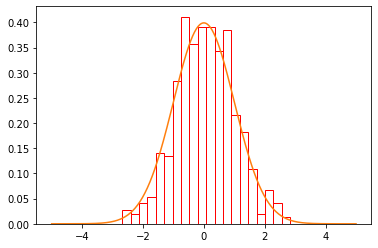

In [18]:
x_1 = np.linspace(-5, 5, 500)
plt.hist(x, 20, density=True, fill=False, edgecolor='red');
plt.plot(x_1, true_dist(case=0)[0](x_1));



### Double gaussian

In [19]:
y, x, z, sigma, error = generate_noisy_sample(N=500, case_dist=1, case_err=1)

Got 665 samples


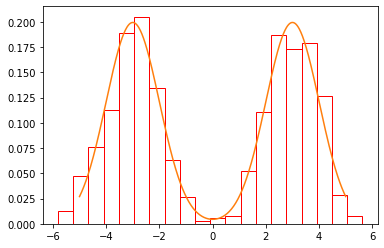

In [20]:
plt.hist(x, 20, density=True, fill=False, edgecolor='red');
plt.plot(x_1, true_dist(case=1)[0](x_1));



### Asymmetric dist.

In [21]:
y, x, z, sigma, error = generate_noisy_sample(N=500, case_dist=2, case_err=1)

Got 341 samples


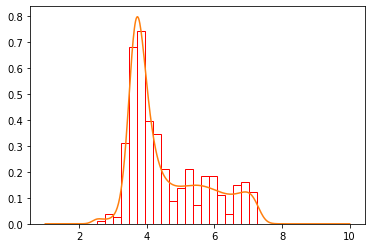

In [22]:
x_2 = np.linspace(1, 10, 500)
plt.hist(x, 20, density=True, fill=False, edgecolor='red');
plt.plot(x_2, true_dist(case=2)[0](x_2));

